In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
datasetname = 'combo_001'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

hr_tifs = dataset/'hr'
lr_tifs = dataset/'lr'
lr_up_tifs = dataset/'lr_up'

mname = 'combo'
model_dir = 'models'

loss = F.mse_loss
metrics = sr_metrics

In [4]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data)
        return y_data_/hr_name
    src = (ImageImageList
            .from_folder(x_data, convert_mode='L')
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1):
    src = get_src(x_data, y_data)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs))
    data.c = 3
    return data

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.to_fp16().fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
if True:
    learn.lr_find()
    learn.recorder.plot()

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.333175,0.005023,0.446097,23.025007,00:43
1,0.094442,0.006108,0.469816,22.166986,00:42
2,0.033697,0.003157,0.553324,25.051847,00:42
3,0.013488,0.002128,0.598909,26.775400,00:43
4,0.006063,0.001727,0.632106,27.690342,00:43


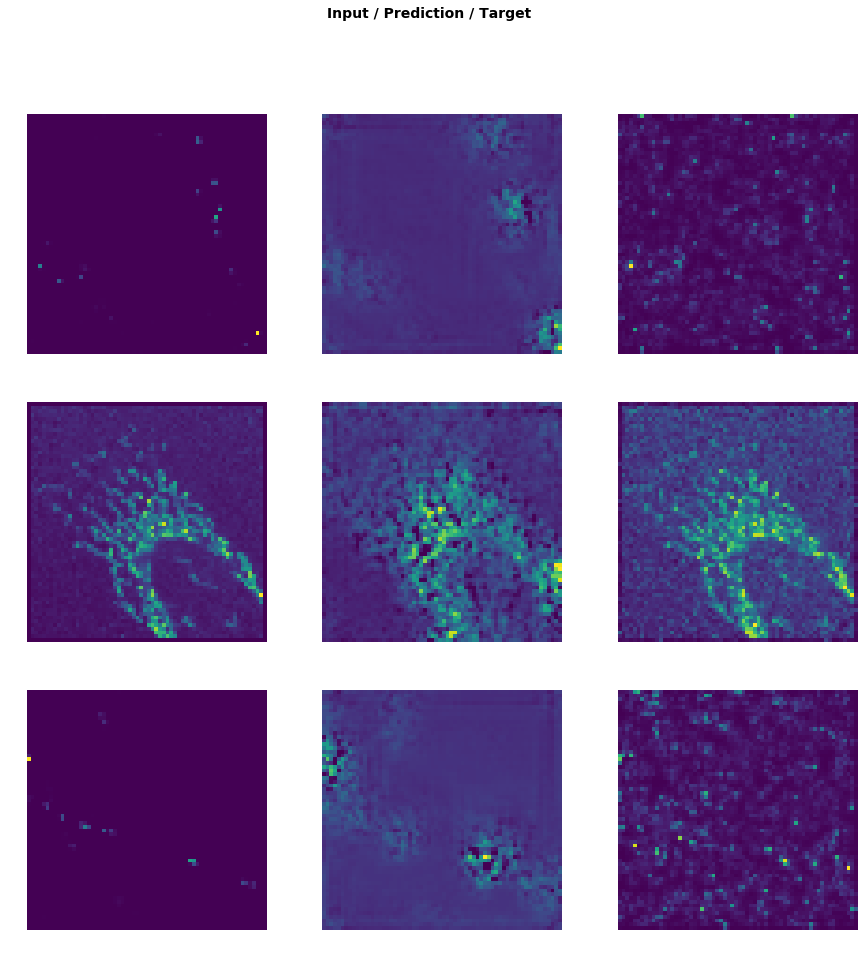

In [7]:
step = 0
lr = 1e-3
cycles = 5

bs = 300
size = 64
max_zoom = 8
arch = xresnet34

data = get_data(bs, size, hr_tifs, lr_up_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
gc.collect()

do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.002214,0.001763,0.626518,27.831223,06:56
1,0.002265,0.001692,0.630853,27.930294,06:44
2,0.001886,0.001670,0.650323,27.996410,06:46


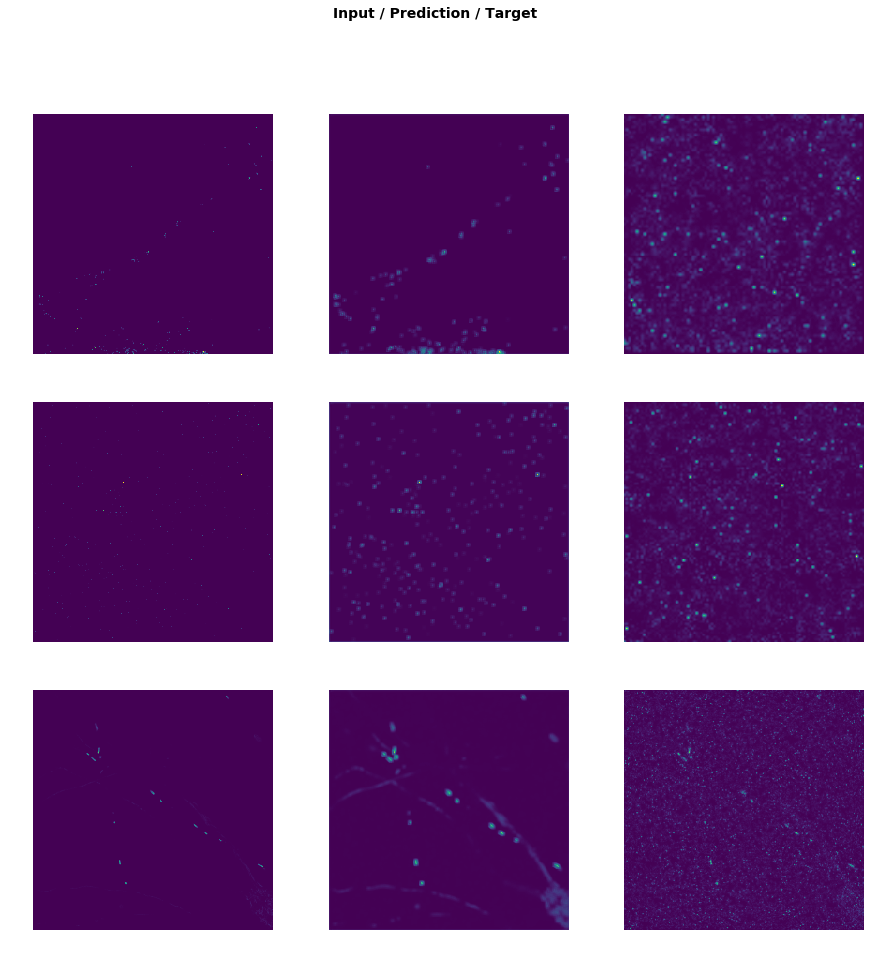

In [8]:
step = 1
lr = 1e-3
cycles = 3

bs = 20
size = 256
max_zoom = 8
arch = xresnet34

data = get_data(bs, size, hr_tifs, lr_up_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
gc.collect()

if Path(f'{mname}.{(step-1):02d}').exists(): 
    print('loading', f'{mname}.{(step-1):02d}')
    learn.load(f'{mname}.{(step-1):02d}')

do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
lr = 1e-3
bs = 10
img_size = 512
arch = xresnet34
learn = xres_unet_learner(bs, img_size, arch)
learn = learn.load(f'{mname}.1')

do_fit(learn, f'{mname}.2', lrs=lr/10, cycle_len=2)